In [2]:
import json
import numpy as np
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import nltk


# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/kchoi22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kchoi22/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kchoi22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kchoi22/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Function to load JSON data into a DataFrame
def load_json_to_df(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return pd.DataFrame.from_dict(data, orient='index')

# List of JSON files
json_files = ['HR_prep.json', 'HF_prep.json', 'MR_prep.json', 'MF_prep.json', 'PHF.json', 'PHR.json', 'PMF.json', 'PMR.json']
dfs = []

# Load each JSON file into a DataFrame and store them in a list
for json_file in json_files:
    df_path = f'data/{json_file}'  # Corrected file path string formation
    df = load_json_to_df(df_path)
    dfs.append(df)

# Naming the DataFrames, ensure you have all 8 DataFrames named if using them distinctly
HR_df, HF_df, MR_df, MF_df, PHF_df, PHR_df, PMF_df, PMR_df = dfs

In [4]:
HR = HR_df['preprocessed_text']
HF = HF_df['preprocessed_text']
MR = MR_df['preprocessed_text']
MF = MF_df['preprocessed_text']

# Extracting 'text' columns for PolitiFact datasets
PHR = PHR_df['text']
PHF = PHF_df['text']
PMR = PMR_df['text']
PMF = PMF_df['text']

In [5]:
df = pd.concat([HR, HF, MR, MF], ignore_index=True)

In [6]:
from nltk import FreqDist
from collections import Counter

# Function to load and tokenize the text from a DataFrame
def load_and_tokenize_text(json_file):
    df = load_json_to_df(json_file)
    # Tokenize each item in the 'text' column
    df['tokens'] = df['preprocessed_text'].apply(word_tokenize)
    return df

# List of JSON files
json_files = ['HR_prep.json', 'HF_prep.json', 'MR_prep.json', 'MF_prep.json']
category_data = []

# Load and tokenize each JSON file into a DataFrame and store them in a list
for json_file in json_files:
    df = load_and_tokenize_text('data/' + json_file)
    category_data.append(df)

# Extract tokenized words for each category
tokens_hr = [token for sublist in category_data[0]['tokens'] for token in sublist]
tokens_hf = [token for sublist in category_data[1]['tokens'] for token in sublist]
tokens_mr = [token for sublist in category_data[2]['tokens'] for token in sublist]
tokens_mf = [token for sublist in category_data[3]['tokens'] for token in sublist]

# Function to display common words within a specific frequency range
def display_common_words(tokens, category_name, min_freq, max_freq):
    # Calculate frequencies of words
    freq_dist = FreqDist(tokens)

    # Filter words within the frequency range and sort by frequency
    filtered_words = {word: count for word, count in freq_dist.items() if min_freq <= count <= max_freq}
    sorted_filtered_words = dict(sorted(filtered_words.items(), key=lambda item: item[1], reverse=True))


In [7]:
from nltk import FreqDist

# Combine all tokens from each dataset
all_tokens = tokens_hr + tokens_hf + tokens_mr + tokens_mf

# Calculate the frequency distribution of all tokens
freq_dist = FreqDist(all_tokens)

# Filter tokens by frequency range
filtered_tokens = {word for word, count in freq_dist.items() if 100 <= count <= 2000}

In [8]:
def filter_text(text, filtered_vocab):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Filter tokens based on the frequency-filtered vocabulary
    filtered_text = ' '.join([token for token in tokens if token in filtered_vocab])
    return ' '.join(filtered_text)

In [9]:
# Assuming HR_df, HF_df, MR_df, MF_df are the original DataFrames containing a 'preprocessed_text' column
HR_df['filtered_text'] = HR_df['preprocessed_text'].apply(lambda text: filter_text(text, filtered_tokens))
HF_df['filtered_text'] = HF_df['preprocessed_text'].apply(lambda text: filter_text(text, filtered_tokens))
MR_df['filtered_text'] = MR_df['preprocessed_text'].apply(lambda text: filter_text(text, filtered_tokens))
MF_df['filtered_text'] = MF_df['preprocessed_text'].apply(lambda text: filter_text(text, filtered_tokens))

In [10]:
from sklearn.metrics import accuracy_score, classification_report

# Assigning labels for each comparison

labels_mr_vs_mf = [0] * len(MR) + [1] * len(MF)

labels_hr_vs_hf = [0] * len(HR) + [1] * len(HF)

#Separate for Human vs AI in general
labels_hr_hf = [0] * (len(HR) + len(HF))
labels_mr_mf = [1] * (len(MR) + len(MF))

labels_human_machine = labels_hr_hf + labels_mr_mf

In [11]:
# Splitting the data for each comparison

X_train_mr_vs_mf, X_test_mr_vs_mf, y_train_mr_vs_mf, y_test_mr_vs_mf = train_test_split(pd.concat([MR, MF], ignore_index=True), labels_mr_vs_mf, test_size=0.2, random_state=42)

X_train_hr_vs_hf, X_test_hr_vs_hf, y_train_hr_vs_hf, y_test_hr_vs_hf = train_test_split(pd.concat([HR, HF], ignore_index=True), labels_hr_vs_hf, test_size=0.2, random_state=42)

# Splitting the data for the comparison between human-generated and machine-generated text
X_train_human_machine, X_test_human_machine, y_train_human_machine, y_test_human_machine = train_test_split(pd.concat([pd.concat([HR, HF]), pd.concat([MR, MF])], ignore_index=True),labels_human_machine,test_size=0.2,random_state=42)

In [12]:
tfidf_vectorizer_mr_vs_mf = TfidfVectorizer(max_features=30000)
X_train_mr_vs_mf_tfidf = tfidf_vectorizer_mr_vs_mf.fit_transform(X_train_mr_vs_mf)
X_test_mr_vs_mf_tfidf = tfidf_vectorizer_mr_vs_mf.transform(X_test_mr_vs_mf)


tfidf_vectorizer_hr_vs_hf = TfidfVectorizer(max_features=30000)
X_train_hr_vs_hf_tfidf = tfidf_vectorizer_hr_vs_hf.fit_transform(X_train_hr_vs_hf)
X_test_hr_vs_hf_tfidf = tfidf_vectorizer_hr_vs_hf.transform(X_test_hr_vs_hf)


# Create TF-IDF vectorizer for human vs. machine comparison
tfidf_vectorizer_human_machine = TfidfVectorizer(max_features=30000)
X_train_human_machine_tfidf = tfidf_vectorizer_human_machine.fit_transform(X_train_human_machine)
X_test_human_machine_tfidf = tfidf_vectorizer_human_machine.transform(X_test_human_machine)

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to train SVM and return the model and metrics
def train_and_evaluate_svm(X_train_tfidf, y_train, X_test_tfidf, y_test):
    # Create and train the SVM model
    svm_model = SVC(kernel='linear')  # Using a linear kernel
    svm_model.fit(X_train_tfidf, y_train)
    
    # Predict on the test set
    y_pred = svm_model.predict(X_test_tfidf)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return svm_model, accuracy, cm

# Train SVM models for each text comparison
svm_human_machine, accuracy_human_machine, cm_human_machine = train_and_evaluate_svm(X_train_human_machine_tfidf, y_train_human_machine, X_test_human_machine_tfidf, y_test_human_machine)
svm_hr_vs_hf, accuracy_hr_vs_hf, cm_hr_vs_hf = train_and_evaluate_svm(X_train_hr_vs_hf_tfidf, y_train_hr_vs_hf, X_test_hr_vs_hf_tfidf, y_test_hr_vs_hf)
svm_mr_vs_mf, accuracy_mr_vs_mf, cm_mr_vs_mf = train_and_evaluate_svm(X_train_mr_vs_mf_tfidf, y_train_mr_vs_mf, X_test_mr_vs_mf_tfidf, y_test_mr_vs_mf)


In [14]:
print("Accuracy for Human vs. Machine:", accuracy_human_machine)
print("Confusion Matrix:\n", cm_human_machine)
print("Accuracy for Human Real vs. Human Fake:", accuracy_hr_vs_hf)
print("Confusion Matrix:\n", cm_hr_vs_hf)
print("Accuracy for Machine Real vs. Machine Fake:", accuracy_mr_vs_mf)
print("Confusion Matrix:\n", cm_mr_vs_mf)


Accuracy for Human vs. Machine: 0.9220739842328685
Confusion Matrix:
 [[1574   77]
 [ 180 1467]]
Accuracy for Human Real vs. Human Fake: 0.7955097087378641
Confusion Matrix:
 [[699 141]
 [196 612]]
Accuracy for Machine Real vs. Machine Fake: 0.9588128407026045
Confusion Matrix:
 [[821  29]
 [ 39 762]]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X, y, ax=None, cmap=plt.cm.Blues, display_labels=None):
    cm = confusion_matrix(y, model.predict(X))
    if ax is None:
        fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if display_labels is None:
        display_labels = np.unique(y)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=display_labels, yticklabels=display_labels,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)
    return ax


In [17]:
# Plot for Human vs. Machine Generated texts
plot_confusion_matrix(svm_human_machine, X_test_human_machine_tfidf, y_test_human_machine, display_labels=['Human', 'Machine'])
plt.show()


KeyboardInterrupt: 

In [ ]:
# Plot for Human Real vs. Human Fake
plot_confusion_matrix(svm_hr_vs_hf, X_test_hr_vs_hf_tfidf, y_test_hr_vs_hf, display_labels=['Human Real', 'Human Fake'])
plt.show()


In [ ]:
# Plot for Machine Real vs. Machine Fake
plot_confusion_matrix(svm_mr_vs_mf, X_test_mr_vs_mf_tfidf, y_test_mr_vs_mf, display_labels=['Machine Real', 'Machine Fake'])
plt.show()


In [31]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(model, X, y, title, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Mean and standard deviation of training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid(True)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, color="r", alpha=0.1)
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, color="g", alpha=0.1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Validation score")
    
    plt.legend(loc="best")
    plt.show()


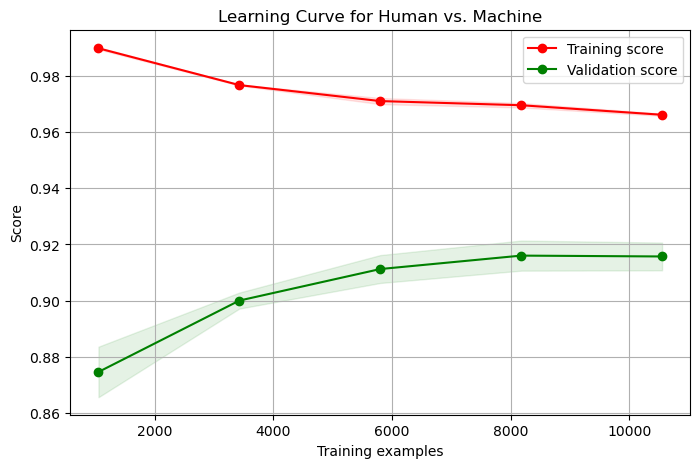

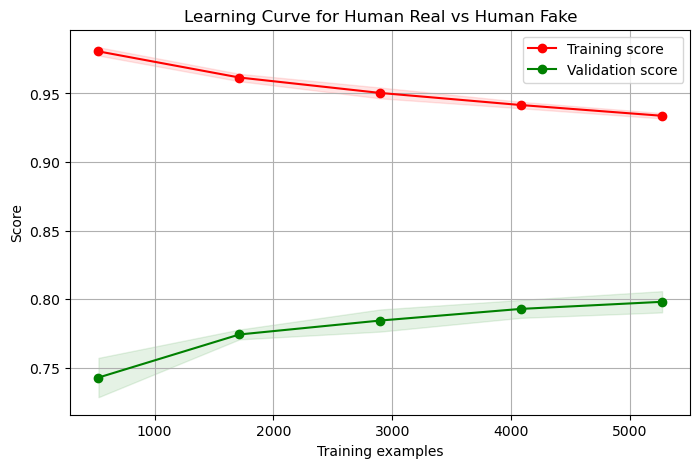

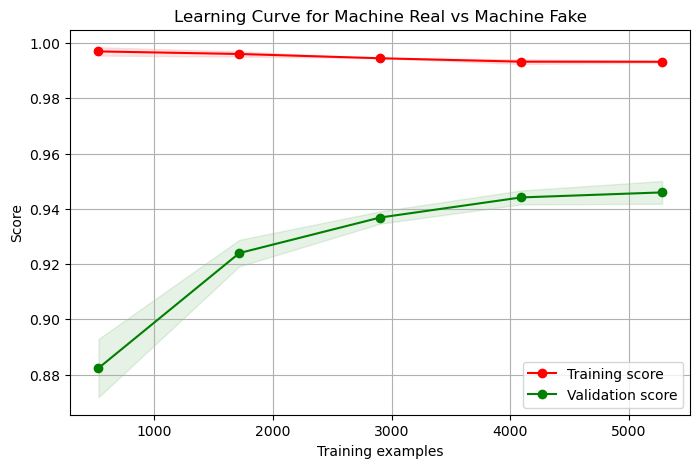

In [30]:
# Assuming models are initialized and X/y data is ready
svm_human_machine = SVC(kernel='linear')  # Example initialization
svm_hr_vs_hf = SVC(kernel='linear')
svm_mr_vs_mf = SVC(kernel='linear')

# Plot Learning Curve for Human vs. Machine
plot_learning_curve(svm_human_machine, X_train_human_machine_tfidf, y_train_human_machine, 'Learning Curve for Human vs. Machine', cv=5)

# Plot Learning Curve for Human Real vs Human Fake
plot_learning_curve(svm_hr_vs_hf, X_train_hr_vs_hf_tfidf, y_train_hr_vs_hf, 'Learning Curve for Human Real vs Human Fake', cv=5)

# Plot Learning Curve for Machine Real vs Machine Fake
plot_learning_curve(svm_mr_vs_mf, X_train_mr_vs_mf_tfidf, y_train_mr_vs_mf, 'Learning Curve for Machine Real vs Machine Fake', cv=5)


#### Testing With Poltifact Data

In [19]:
import re
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in tokens if word not in stop_words])
    return filtered_text

# Apply the preprocessing function to each DataFrame
for df in [PHR_df, PHF_df, PMF_df, PMR_df]:
    df['text_clean'] = df['text'].apply(remove_stopwords)


In [20]:
# Ensure correct initial labeling
PHR_df['label'] = 0  # Human Real
PHF_df['label'] = 1  # Human Fake
PMR_df['label'] = 0  # Machine Real
PMF_df['label'] = 1  # Machine Fake

# Correctly combine datasets for each comparison
df_human = pd.concat([PHR_df, PHF_df], ignore_index=True)
df_machine = pd.concat([PMR_df, PMF_df], ignore_index=True)

# Combine into a single dataset for Human vs. Machine
all_texts = pd.concat([df_human, df_machine], ignore_index=True)
# Check label distribution again to ensure correctness
print("Label distribution in Human dataset:")
print(df_human['label'].value_counts())

print("Label distribution in Machine dataset:")
print(df_machine['label'].value_counts())

print("Label distribution in All Texts dataset:")
print(all_texts['label'].value_counts())



Label distribution in Human dataset:
label
0    194
1     97
Name: count, dtype: int64
Label distribution in Machine dataset:
label
0    132
1     97
Name: count, dtype: int64
Label distribution in All Texts dataset:
label
0    326
1    194
Name: count, dtype: int64


In [21]:
tfidf_vectorizer = TfidfVectorizer(max_features=30000)
tfidf_vectorizer.fit(all_texts['text_clean'])  # Fit the vectorizer on the combined dataset

# Transform text data for each comparison
X_human = tfidf_vectorizer.transform(df_human['text_clean'])
X_machine = tfidf_vectorizer.transform(df_machine['text_clean'])
X_all_texts = tfidf_vectorizer.transform(all_texts['text_clean'])

y_human = df_human['label']
y_machine = df_machine['label']
y_all_texts = all_texts['label']

In [22]:
X_human_train, X_human_test, y_human_train, y_human_test = train_test_split(
    X_human, y_human, test_size=0.2, random_state=42, stratify=y_human)

X_machine_train, X_machine_test, y_machine_train, y_machine_test = train_test_split(
    X_machine, y_machine, test_size=0.2, random_state=42, stratify=y_machine)

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    X_all_texts, y_all_texts, test_size=0.2, random_state=42, stratify=y_all_texts)

In [23]:
# Train and evaluate models
svm_human, accuracy_human, cm_human = train_and_evaluate_svm(X_human_train, y_human_train, X_human_test, y_human_test)
svm_machine, accuracy_machine, cm_machine = train_and_evaluate_svm(X_machine_train, y_machine_train, X_machine_test, y_machine_test)
svm_all_texts, accuracy_all_texts, cm_all_texts = train_and_evaluate_svm(X_all_train, y_all_train, X_all_test, y_all_test)


In [24]:
# Print accuracy scores
print("Accuracy for All Texts (Human vs. Machine):", accuracy_all_texts)
print("Accuracy for Human Real vs. Human Fake:", accuracy_human)
print("Accuracy for Machine Real vs. Machine Fake:", accuracy_machine)

Accuracy for All Texts (Human vs. Machine): 0.9326923076923077
Accuracy for Human Real vs. Human Fake: 0.7966101694915254
Accuracy for Machine Real vs. Machine Fake: 0.8913043478260869


In [25]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title, labels=['Human', 'Machine']):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title(title, pad=20)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()


/var/folders/vp/p8xmvgdn3llb1mbqht8mc0t80000gn/T/ipykernel_39086/2955461843.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
/var/folders/vp/p8xmvgdn3llb1mbqht8mc0t80000gn/T/ipykernel_39086/2955461843.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


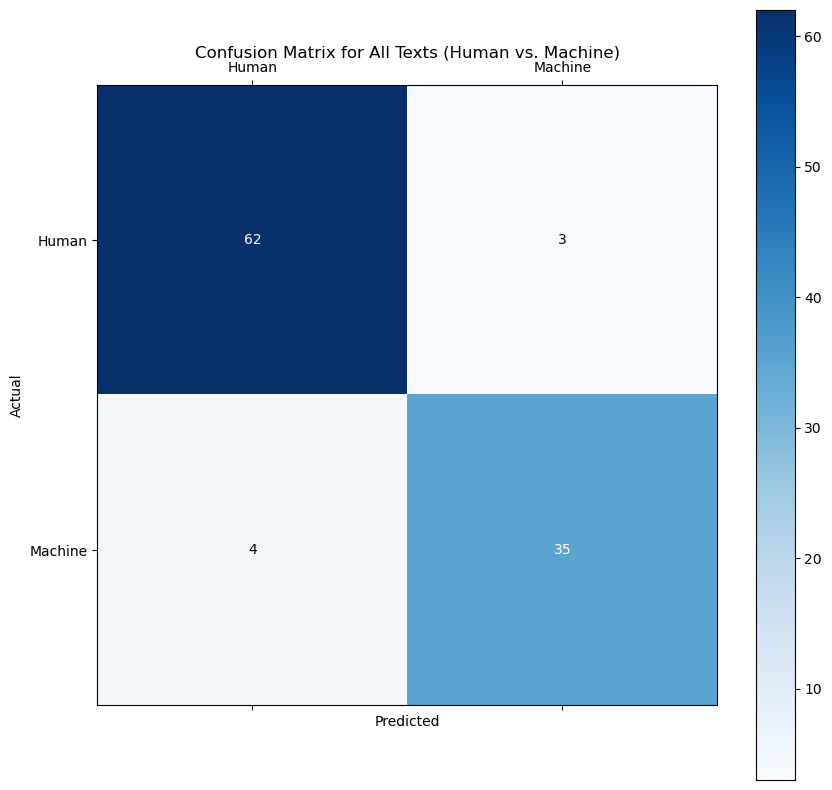

/var/folders/vp/p8xmvgdn3llb1mbqht8mc0t80000gn/T/ipykernel_39086/2955461843.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
/var/folders/vp/p8xmvgdn3llb1mbqht8mc0t80000gn/T/ipykernel_39086/2955461843.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


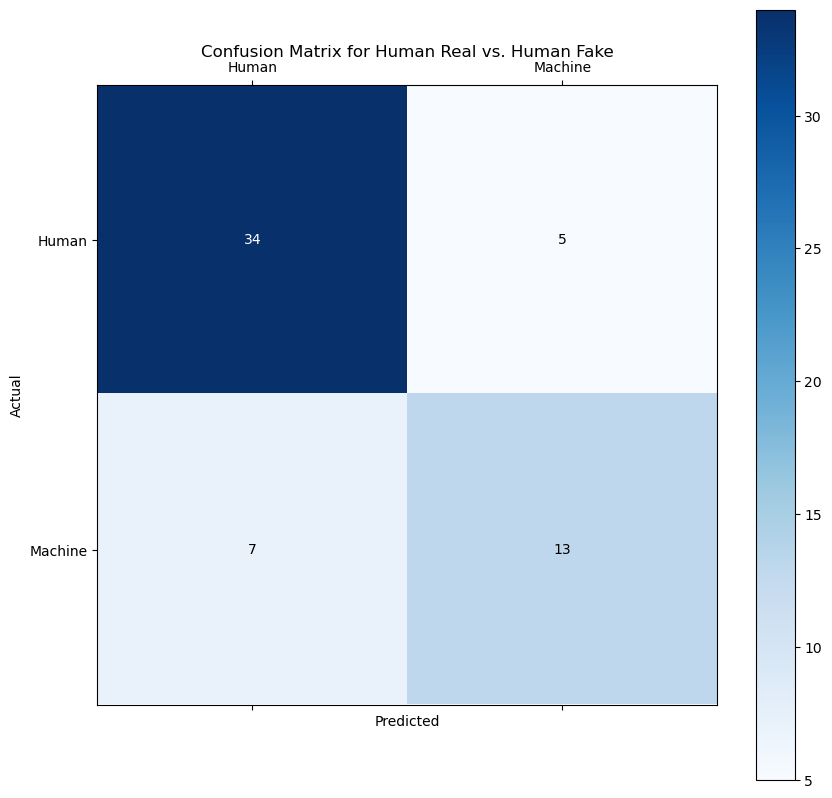

/var/folders/vp/p8xmvgdn3llb1mbqht8mc0t80000gn/T/ipykernel_39086/2955461843.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
/var/folders/vp/p8xmvgdn3llb1mbqht8mc0t80000gn/T/ipykernel_39086/2955461843.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


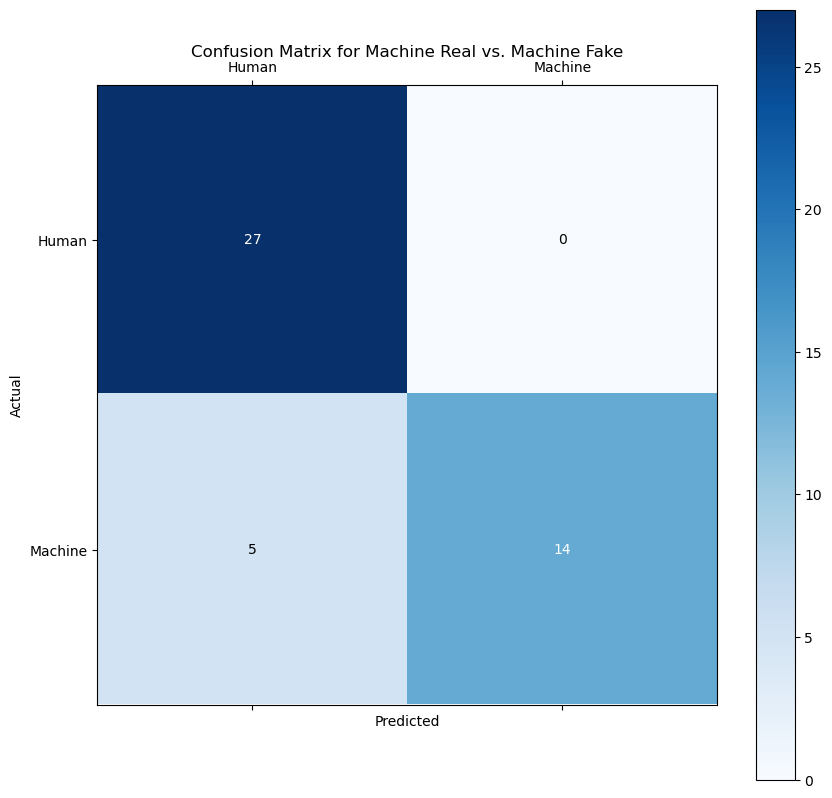

In [26]:
# Visualize confusion matrices
plot_confusion_matrix(cm_all_texts, 'Confusion Matrix for All Texts (Human vs. Machine)')
plot_confusion_matrix(cm_human, 'Confusion Matrix for Human Real vs. Human Fake')
plot_confusion_matrix(cm_machine, 'Confusion Matrix for Machine Real vs. Machine Fake')

#### Cross-Validation

In [27]:
from sklearn.model_selection import cross_val_score
svm_model = SVC(kernel='linear')
# Example using 5-fold cross-validation
scores = cross_val_score(svm_model, X_all_texts, y_all_texts, cv=10)
print("Cross-validation scores:", scores)
print("Average cross-validation score: {:.2f}".format(scores.mean()))


Cross-validation scores: [0.92307692 0.92307692 0.96153846 0.94230769 0.96153846 0.96153846
 0.98076923 0.90384615 0.98076923 0.94230769]
Average cross-validation score: 0.95


In [28]:
scores_human = cross_val_score(svm_model, X_human, y_human, cv=10)
print("Human Real vs. Human Fake - Cross-validation scores:", scores_human)
print("Average score: {:.2f}".format(scores_human.mean()))

Human Real vs. Human Fake - Cross-validation scores: [0.86666667 0.89655172 0.86206897 0.89655172 0.86206897 0.86206897
 0.79310345 0.75862069 0.82758621 0.86206897]
Average score: 0.85


In [29]:
scores_machine = cross_val_score(svm_model, X_machine, y_machine, cv=10)
print("Machine Real vs. Machine Fake - Cross-validation scores:", scores_machine)
print("Average score: {:.2f}".format(scores_machine.mean()))


Machine Real vs. Machine Fake - Cross-validation scores: [0.91304348 1.         0.95652174 0.95652174 0.95652174 0.82608696
 0.7826087  0.95652174 1.         0.86363636]
Average score: 0.92


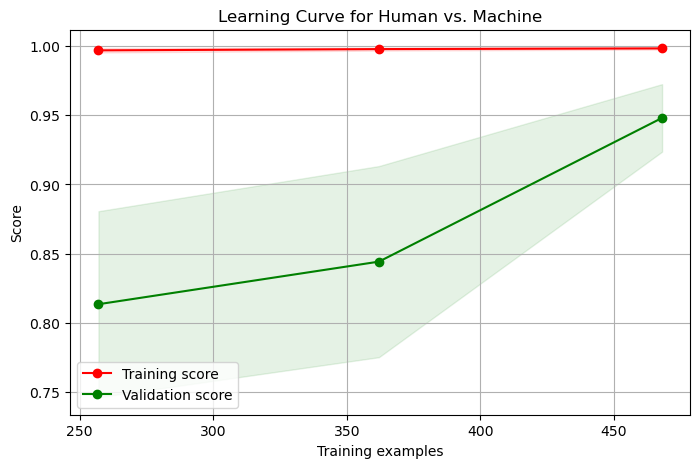

In [33]:
# Human vs. Machine in general learning trends
plot_learning_curve(svm_model, X_all_texts, y_all_texts, "Learning Curve for Human vs. Machine", cv=10)

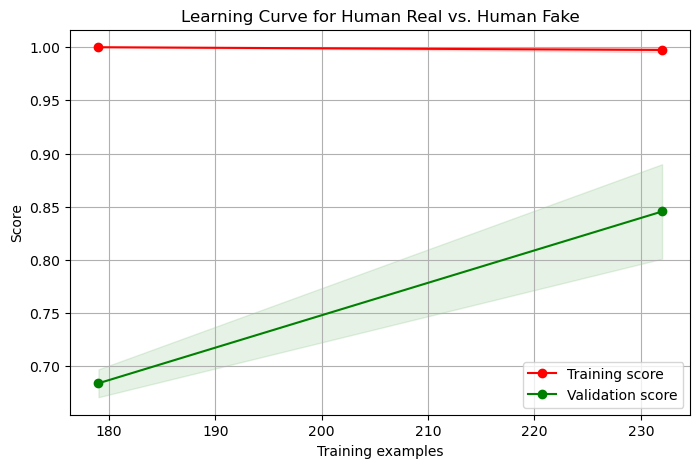

In [34]:
# Human Real vs. Human Fake
plot_learning_curve(svm_model, X_human, y_human, "Learning Curve for Human Real vs. Human Fake", cv=5)

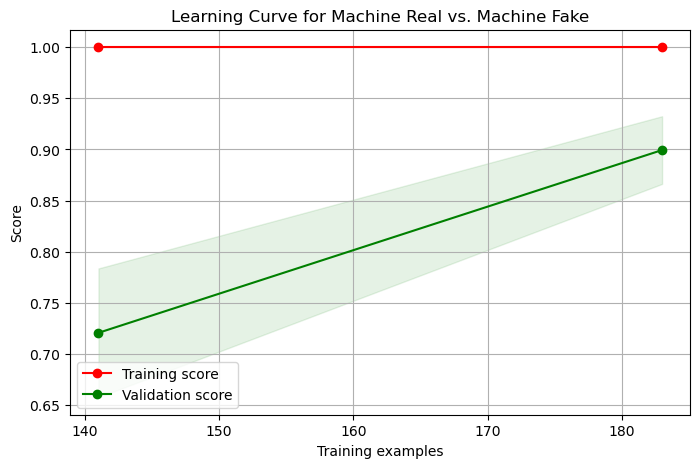

In [35]:
# Machine Real vs. Machine Fake
plot_learning_curve(svm_model, X_machine, y_machine, "Learning Curve for Machine Real vs. Machine Fake", cv=5)

In [17]:
import joblib

# Save each vectorizer
joblib.dump(tfidf_vectorizer_mr_vs_mf, 'tfidf_vectorizer_mr_vs_mf.joblib')
joblib.dump(tfidf_vectorizer_hr_vs_hf, 'tfidf_vectorizer_hr_vs_hf.joblib')
joblib.dump(tfidf_vectorizer_human_machine, 'tfidf_vectorizer_human_machine.joblib')

['tfidf_vectorizer_human_machine.joblib']

In [18]:
from sklearn.svm import SVC

def train_svm(X_train_tfidf, y_train):
    svm_model = SVC(kernel='linear') 
    svm_model.fit(X_train_tfidf, y_train)
    return svm_model


In [19]:
# Train SVM models for each text comparison
svm_human_machine = train_svm(X_train_human_machine_tfidf, y_train_human_machine)
joblib.dump(svm_human_machine, 'svm_human_machine.joblib')  # Save the Human vs. Machine model

svm_hr_vs_hf = train_svm(X_train_hr_vs_hf_tfidf, y_train_hr_vs_hf)
joblib.dump(svm_hr_vs_hf, 'svm_hr_vs_hf.joblib')  # Save the Human Real vs. Human Fake model

svm_mr_vs_mf = train_svm(X_train_mr_vs_mf_tfidf, y_train_mr_vs_mf)
joblib.dump(svm_mr_vs_mf, 'svm_mr_vs_mf.joblib')  # Save the Machine Real vs. Machine Fake model


['svm_mr_vs_mf.joblib']